In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [2]:
sys.path.append('../../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [3]:
import elitism

In [4]:
x0,y0=7,7
dim3 = 3*x0*y0

### Finite Element Model - The Linear Tetrahedral (Solid) Element (from MATLAB Guide to Finite Elements)

In [5]:
def TetrahedronElementVolume(x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4):
    xyz = np.array([[1, x1, y1, z1],
                    [1, x2, y2, z2], 
                    [1, x3, y3, z3],
                    [1, x4, y4, z4]])
    y = np.linalg.det(xyz)/6
    return y

In [6]:
TetrahedronElementVolume(1, 2, 3, 2, 4, 2, 3, 1, 2, 4, 4, 3)

-1.8333333333333337

In [7]:
def TetrahedronElementStiffness(E,NU,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4):
    
    xyz = np.array([[1, x1, y1, z1],
                    [1, x2, y2, z2], 
                    [1, x3, y3, z3],
                    [1, x4, y4, z4]])
    V = np.linalg.det(xyz)/6
    
    mbeta1 = np.array([[1, y2, z2], [ 1, y3, z3], [1, y4, z4]])
    mbeta2 = np.array([[1, y1, z1],  [1, y3, z3],  [1, y4, z4]])
    mbeta3 = np.array([[1, y1, z1],  [1, y2, z2], [ 1, y4, z4]])
    mbeta4 = np.array([[1, y1, z1], [1, y2, z2], [ 1, y3, z3]])
    mgamma1 = np.array([[1, x2, z2], [1, x3, z3], [1, x4, z4]])
    mgamma2 = np.array([[1, x1, z1], [1, x3, z3], [ 1, x4, z4]])
    mgamma3 = np.array([[1, x1, z1], [1, x2, z2], [1, x4, z4]])
    mgamma4 = np.array([[1, x1, z1], [1, x2, z2], [ 1, x3, z3]])
    mdelta1 = np.array([[1, x2, y2],  [1, x3, y3], [ 1, x4, y4]])
    mdelta2 = np.array([[1, x1, y1], [1, x3, y3], [1, x4, y4]])
    mdelta3 = np.array([[1, x1, y1], [ 1, x2, y2], [1, x4, y4]])
    mdelta4 = np.array([[1, x1, y1], [1, x2, y2], [1, x3, y3]])
    beta1 = -1*np.linalg.det(mbeta1)
    beta2 = np.linalg.det(mbeta2)
    beta3 = -1*np.linalg.det(mbeta3)
    beta4 = np.linalg.det(mbeta4)
    gamma1 = np.linalg.det(mgamma1)
    gamma2 = -1*np.linalg.det(mgamma2)
    gamma3 = np.linalg.det(mgamma3)
    gamma4 = -1*np.linalg.det(mgamma4)
    delta1 = -1*np.linalg.det(mdelta1)
    delta2 = np.linalg.det(mdelta2)
    delta3 = -1*np.linalg.det(mdelta3)
    delta4 = np.linalg.det(mdelta4)
    B1 = np.array([[beta1, 0, 0], 
                   [0, gamma1, 0], 
                   [0, 0, delta1],
                   [gamma1, beta1, 0], 
                   [0, delta1, gamma1], 
                   [delta1, 0, beta1]])
    B2 = np.array([[beta2, 0, 0], 
                   [0, gamma2, 0], 
                   [0, 0, delta2], 
                   [gamma2, beta2, 0], 
                   [0, delta2, gamma2], 
                   [delta2, 0, beta2]])
    B3 = np.array([[beta3, 0, 0], 
                   [0, gamma3, 0], 
                   [0, 0, delta3], 
                   [gamma3, beta3, 0], 
                   [0, delta3, gamma3], 
                   [delta3, 0, beta3]])
    B4 = np.array([[beta4, 0, 0],
                   [0, gamma4, 0], 
                   [0, 0, delta4],
                   [gamma4, beta4, 0], 
                   [0, delta4, gamma4], 
                   [delta4, 0, beta4]])
    B = np.concatenate([B1, B2, B3, B4],axis=1)/(6*V)
#     print(B)
    D = (E/((1+NU)*(1-2*NU)))*np.array([[1-NU, NU, NU, 0, 0, 0], 
    [NU, 1-NU, NU, 0, 0, 0], 
    [NU, NU, 1-NU, 0, 0, 0], 
    [0, 0, 0, (1-2*NU)/2, 0, 0], 
    [0, 0, 0, 0, (1-2*NU)/2, 0],
    [0, 0, 0, 0, 0, (1-2*NU)/2]])

    y = V*(B.T@D@B)
    return y

In [8]:
NU = 0.3000
E = 210e6

In [9]:
TetrahedronElementStiffness(E, NU, 0, 0, 0, 0.025, 0, 0, 0.025, 0.5, 0, 0.025, 0, 0.25)

array([[ 2.35576923e+08,  0.00000000e+00,  0.00000000e+00,
        -2.35576923e+08,  5.04807692e+06,  1.00961538e+07,
         0.00000000e+00, -5.04807692e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.00961538e+07],
       [ 0.00000000e+00,  6.73076923e+07,  0.00000000e+00,
         3.36538462e+06, -6.73076923e+07,  0.00000000e+00,
        -3.36538462e+06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.73076923e+07,
         6.73076923e+06,  0.00000000e+00, -6.73076923e+07,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -6.73076923e+06,  0.00000000e+00,  0.00000000e+00],
       [-2.35576923e+08,  3.36538462e+06,  6.73076923e+06,
         2.36418269e+08, -8.41346154e+06, -1.68269231e+07,
        -1.68269231e+05,  5.04807692e+06,  0.00000000e+00,
        -6.73076923e+05,  0.00000000e+00,  1.00961538e+07],
       [ 5.04807692e+06, -6.73076923e+07,  0.0000000

In [10]:
def TetrahedronAssemble(K,k,i,j,m,n):
    K[3*i,3*i] = K[3*i,3*i] + k[0,0]
    K[3*i,3*i+1] = K[3*i,3*i+1] + k[0,1]
    K[3*i,3*i+2] = K[3*i,3*i+2] + k[0,2]
    K[3*i,3*j] = K[3*i,3*j] + k[0,3]
    K[3*i,3*j+1] = K[3*i,3*j+1] + k[0,4]
    K[3*i,3*j+2] = K[3*i,3*j+2] + k[0,5]
    K[3*i,3*m] = K[3*i,3*m] + k[0,6]
    K[3*i,3*m+1] = K[3*i,3*m+1] + k[0,7]
    K[3*i,3*m+2] = K[3*i,3*m+2] + k[0,8]
    K[3*i,3*n] = K[3*i,3*n] + k[0,9]
    K[3*i,3*n+1] = K[3*i,3*n+1] + k[0,10]
    K[3*i,3*n+2] = K[3*i,3*n+2] + k[0,11]
    K[3*i+1,3*i] = K[3*i+1,3*i] + k[1,0]
    K[3*i+1,3*i+1] = K[3*i+1,3*i+1] + k[1,1]
    K[3*i+1,3*i+2] = K[3*i+1,3*i+2] + k[1,2]
    K[3*i+1,3*j] = K[3*i+1,3*j] + k[1,3]
    K[3*i+1,3*j+1] = K[3*i+1,3*j+1] + k[1,4]
    K[3*i+1,3*j+2] = K[3*i+1,3*j+2] + k[1,5]
    K[3*i+1,3*m] = K[3*i+1,3*m] + k[1,6]
    K[3*i+1,3*m+1] = K[3*i+1,3*m+1] + k[1,7]
    K[3*i+1,3*m+2] = K[3*i+1,3*m+2] + k[1,8]
    K[3*i+1,3*n] = K[3*i+1,3*n] + k[1,9]
    K[3*i+1,3*n+1] = K[3*i+1,3*n+1] + k[1,10]
    K[3*i+1,3*n+2] = K[3*i+1,3*n+2] + k[1,11]
    K[3*i+2,3*i] = K[3*i+2,3*i] + k[2,0]
    K[3*i+2,3*i+1] = K[3*i+2,3*i+1] + k[2,1]
    K[3*i+2,3*i+2] = K[3*i+2,3*i+2] + k[2,2]
    K[3*i+2,3*j] = K[3*i+2,3*j] + k[2,3]
    K[3*i+2,3*j+1] = K[3*i+2,3*j+1] + k[2,4]
    K[3*i+2,3*j+2] = K[3*i+2,3*j+2] + k[2,5]
    K[3*i+2,3*m] = K[3*i+2,3*m] + k[2,6]
    K[3*i+2,3*m+1] = K[3*i+2,3*m+1] + k[2,7]
    K[3*i+2,3*m+2] = K[3*i+2,3*m+2] + k[2,8]
    K[3*i+2,3*n] = K[3*i+2,3*n] + k[2,9]
    K[3*i+2,3*n+1] = K[3*i+2,3*n+1] + k[2,10]
    K[3*i+2,3*n+2] = K[3*i+2,3*n+2] + k[2,11]
    K[3*j,3*i] = K[3*j,3*i] + k[3,0]
    K[3*j,3*i+1] = K[3*j,3*i+1] + k[3,1]
    K[3*j,3*i+2] = K[3*j,3*i+2] + k[3,2]
    K[3*j,3*j] = K[3*j,3*j] + k[3,3]
    K[3*j,3*j+1] = K[3*j,3*j+1] + k[3,4]
    K[3*j,3*j+2] = K[3*j,3*j+2] + k[3,5]
    K[3*j,3*m] = K[3*j,3*m] + k[3,6]
    K[3*j,3*m+1] = K[3*j,3*m+1] + k[3,7]
    K[3*j,3*m+2] = K[3*j,3*m+2] + k[3,8]
    K[3*j,3*n] = K[3*j,3*n] + k[3,9]
    K[3*j,3*n+1] = K[3*j,3*n+1] + k[3,10]
    K[3*j,3*n+2] = K[3*j,3*n+2] + k[3,11]
    K[3*j+1,3*i] = K[3*j+1,3*i] + k[4,0]
    K[3*j+1,3*i+1] = K[3*j+1,3*i+1] + k[4,1]
    K[3*j+1,3*i+2] = K[3*j+1,3*i+2] + k[4,2]
    K[3*j+1,3*j] = K[3*j+1,3*j] + k[4,3]
    K[3*j+1,3*j+1] = K[3*j+1,3*j+1] + k[4,4]
    K[3*j+1,3*j+2] = K[3*j+1,3*j+2] + k[4,5]
    K[3*j+1,3*m] = K[3*j+1,3*m] + k[4,6]
    K[3*j+1,3*m+1] = K[3*j+1,3*m+1] + k[4,7]
    K[3*j+1,3*m+2] = K[3*j+1,3*m+2] + k[4,8]
    K[3*j+1,3*n] = K[3*j+1,3*n] + k[4,9]
    K[3*j+1,3*n+1] = K[3*j+1,3*n+1] + k[4,10]
    K[3*j+1,3*n+2] = K[3*j+1,3*n+2] + k[4,11]
    K[3*j+2,3*i] = K[3*j+2,3*i] + k[5,0]
    K[3*j+2,3*i+1] = K[3*j+2,3*i+1] + k[5,1]
    K[3*j+2,3*i+2] = K[3*j+2,3*i+2] + k[5,2]
    K[3*j+2,3*j] = K[3*j+2,3*j] + k[5,3]
    K[3*j+2,3*j+1] = K[3*j+2,3*j+1] + k[5,4]
    K[3*j+2,3*j+2] = K[3*j+2,3*j+2] + k[5,5]
    K[3*j+2,3*m] = K[3*j+2,3*m] + k[5,6]
    K[3*j+2,3*m+1] = K[3*j+2,3*m+1] + k[5,7]
    K[3*j+2,3*m+2] = K[3*j+2,3*m+2] + k[5,8]
    K[3*j+2,3*n] = K[3*j+2,3*n] + k[5,9]
    K[3*j+2,3*n+1] = K[3*j+2,3*n+1] + k[5,10]
    K[3*j+2,3*n+2] = K[3*j+2,3*n+2] + k[5,11]
    K[3*m,3*i] = K[3*m,3*i] + k[6,0]
    K[3*m,3*i+1] = K[3*m,3*i+1] + k[6,1]
    K[3*m,3*i+2] = K[3*m,3*i+2] + k[6,2]
    K[3*m,3*j] = K[3*m,3*j] + k[6,3]
    K[3*m,3*j+1] = K[3*m,3*j+1] + k[6,4]
    K[3*m,3*j+2] = K[3*m,3*j+2] + k[6,5]
    K[3*m,3*m] = K[3*m,3*m] + k[6,6]
    K[3*m,3*m+1] = K[3*m,3*m+1] + k[6,7]
    K[3*m,3*m+2] = K[3*m,3*m+2] + k[6,8]
    K[3*m,3*n] = K[3*m,3*n] + k[6,9]
    K[3*m,3*n+1] = K[3*m,3*n+1] + k[6,10]
    K[3*m,3*n+2] = K[3*m,3*n+2] + k[6,11]
    K[3*m+1,3*i] = K[3*m+1,3*i] + k[7,0]
    K[3*m+1,3*i+1] = K[3*m+1,3*i+1] + k[7,1]
    K[3*m+1,3*i+2] = K[3*m+1,3*i+2] + k[7,2]
    K[3*m+1,3*j] = K[3*m+1,3*j] + k[7,3]
    K[3*m+1,3*j+1] = K[3*m+1,3*j+1] + k[7,4]
    K[3*m+1,3*j+2]= K[3*m+1,3*j+2] + k[7,5]
    K[3*m+1,3*m] = K[3*m+1,3*m] + k[7,6]
    K[3*m+1,3*m+1] = K[3*m+1,3*m+1] + k[7,7]
    K[3*m+1,3*m+2] = K[3*m+1,3*m+2] + k[7,8]
    K[3*m+1,3*n] = K[3*m+1,3*n] + k[7,9]
    K[3*m+1,3*n+1] = K[3*m+1,3*n+1] + k[7,10]
    K[3*m+1,3*n+2] = K[3*m+1,3*n+2] + k[7,11]
    K[3*m+2,3*i] = K[3*m+2,3*i] + k[8,0]
    K[3*m+2,3*i+1] = K[3*m+2,3*i+1] + k[8,1]
    K[3*m+2,3*i+2] = K[3*m+2,3*i+2] + k[8,2]
    K[3*m+2,3*j] = K[3*m+2,3*j] + k[8,3]
    K[3*m+2,3*j+1] = K[3*m+2,3*j+1] + k[8,4]
    K[3*m+2,3*j+2] = K[3*m+2,3*j+2] + k[8,5]
    K[3*m+2,3*m] = K[3*m+2,3*m] + k[8,6]
    K[3*m+2,3*m+1] = K[3*m+2,3*m+1] + k[8,7]
    K[3*m+2,3*m+2] = K[3*m+2,3*m+2] + k[8,8]
    K[3*m+2,3*n] = K[3*m+2,3*n] + k[8,9]
    K[3*m+2,3*n+1] = K[3*m+2,3*n+1] + k[8,10]
    K[3*m+2,3*n+2] = K[3*m+2,3*n+2] + k[8,11]
    K[3*n,3*i] = K[3*n,3*i] + k[9,0]
    K[3*n,3*i+1] = K[3*n,3*i+1] + k[9,1]
    K[3*n,3*i+2] = K[3*n,3*i+2] + k[9,2]
    K[3*n,3*j] = K[3*n,3*j] + k[9,3]
    K[3*n,3*j+1] = K[3*n,3*j+1] + k[9,4]
    K[3*n,3*j+2] = K[3*n,3*j+2] + k[9,5]
    K[3*n,3*m] = K[3*n,3*m] + k[9,6]
    K[3*n,3*m+1] = K[3*n,3*m+1] + k[9,7]
    K[3*n,3*m+2] = K[3*n,3*m+2] + k[9,8]
    K[3*n,3*n] = K[3*n,3*n] + k[9,9]
    K[3*n,3*n+1] = K[3*n,3*n+1] + k[9,10]
    K[3*n,3*n+2] = K[3*n,3*n+2] + k[9,11]
    K[3*n+1,3*i] = K[3*n+1,3*i] + k[10,0]
    K[3*n+1,3*i+1] = K[3*n+1,3*i+1] + k[10,1]
    K[3*n+1,3*i+2] = K[3*n+1,3*i+2] + k[10,2]
    K[3*n+1,3*j] = K[3*n+1,3*j] + k[10,3]
    K[3*n+1,3*j+1] = K[3*n+1,3*j+1] + k[10,4]
    K[3*n+1,3*j+2] = K[3*n+1,3*j+2] + k[10,5]
    K[3*n+1,3*m] = K[3*n+1,3*m] + k[10,6]
    K[3*n+1,3*m+1] = K[3*n+1,3*m+1] + k[10,7]
    K[3*n+1,3*m+2] = K[3*n+1,3*m+2] + k[10,8]
    K[3*n+1,3*n] = K[3*n+1,3*n] + k[10,9]
    K[3*n+1,3*n+1] = K[3*n+1,3*n+1] + k[10,10]
    K[3*n+1,3*n+2] = K[3*n+1,3*n+2] + k[10,11]
    K[3*n+2,3*i] = K[3*n+2,3*i] + k[11,0]
    K[3*n+2,3*i+1] = K[3*n+2,3*i+1] + k[11,1] 
    K[3*n+2,3*i+2] = K[3*n+2,3*i+2] + k[11,2]
    K[3*n+2,3*j] = K[3*n+2,3*j] + k[11,3]
    K[3*n+2,3*j+1] = K[3*n+2,3*j+1] + k[11,4]
    K[3*n+2,3*j+2] = K[3*n+2,3*j+2] + k[11,5]
    K[3*n+2,3*m] = K[3*n+2,3*m] + k[11,6]
    K[3*n+2,3*m+1] = K[3*n+2,3*m+1] + k[11,7]
    K[3*n+2,3*m+2] = K[3*n+2,3*m+2] + k[11,8]
    K[3*n+2,3*n] = K[3*n+2,3*n] + k[11,9]
    K[3*n+2,3*n+1] = K[3*n+2,3*n+1] + k[11,10]
    K[3*n+2,3*n+2] = K[3*n+2,3*n+2] + k[11,11]
    return K

In [11]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, E=210e6, NU=0.3):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    
    K=np.ones(shape=(3*(np.max(elcon)+1),3*(np.max(elcon)+1)))*(1e-4)
    
    
    for el in elcon:
        k=TetrahedronElementStiffness(E,NU,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2],
                                     coord[el[2]][0],coord[el[2]][1],coord[el[2]][2],
                                     coord[el[3]][0],coord[el[3]][1],coord[el[3]][2])
        
        K=TetrahedronAssemble(K, k, el[0], el[1], el[2], el[3])
        
    F = np.array(global_force)
        
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
    compliance = d.T @ K @ d
    
    return d, compliance

In [12]:
d, compliance = FEA_u(np.array([0,0,0,
                                0.025,0,0,
                                0,0.5,0,
                                0.025,0.5,0,
                                0,0,0.25,
                                0.025,0,0.25,
                                0,0.5,0.25,
                                0.025,0.5,0.25
                               ]).reshape(8,3),
        elcon=np.array([[0, 1, 3, 5],
                        [0, 3, 2, 6],
                        [5, 4, 6, 0],
                        [5, 6, 7, 3],
                        [0, 5, 3, 6]]),
        bc_node=list(range(6))+list(range(12,18)), 
        bc_val=[0]*(len(list(range(6))+list(range(12,18)))),
        global_force=[0,0,0,
                      0,0,0,
                      0,3.125,0,
                      0,6.25,0,
                      0,0,0,
                      0,0,0,
                      0,6.25,0,
                      0,3.125,0])

In [13]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.50325850e-09,  6.08198552e-06,
        9.03389989e-08, -1.27015522e-07,  6.07817857e-06,  5.55106245e-08,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.27015469e-07,  6.07817857e-06,
       -5.55106409e-08,  3.50320521e-09,  6.08198552e-06, -9.03390154e-08])

In [14]:
compliance

0.0001139896415962238

In [15]:
def draw(coord, elcon, elev=45, azim=45, color='red', flip=False):
    c = np.array(coord)
    e = np.array(elcon)

    if e.size == 0:
        print("Warning: 'elcon' is empty. Nothing to draw.")
        return

    try:
        coord = c.reshape(np.max(e) + 1, 3)
    except Exception as ex:
        print(f"Error reshaping coord: {ex}")
        return

    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(111, projection='3d')

    for item in e:
        ax.plot([coord[item[0]][0], coord[item[1]][0]],
                [coord[item[0]][1], coord[item[1]][1]],
                [coord[item[0]][2], coord[item[1]][2]],
                color=color, linewidth=1, linestyle='--')

    ax.view_init(elev, azim)
    ax.set_xlim([0, max(x0,y0)])
    ax.set_ylim([0, max(x0,y0)])
    ax.set_zlim([0, max(x0,y0)]) 
    
    if flip:
        ax.set_zlim(ax.get_zlim()[::-1])
        
    plt.show()

In [16]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [17]:
def get_voxel_edge_pairs(volume):
    """
    Extracts node coordinates and all edge (node pair) connections
    from solid voxels in a 3D volume.

    Parameters:
        volume (ndarray): 3D binary voxel array (nx, ny, nz)

    Returns:
        node_coords (ndarray): Unique node coordinates, shape (N_nodes, 3)
        edge_pairs (list of tuple): Each edge as a (node_index_1, node_index_2)
    """
    nx, ny, nz = volume.shape

    node_map = {}
    node_coords = []
    node_id_counter = 0
    edge_pairs = set()  

    
    edge_template=[
                        [0, 1, 3, 5],
                        [0, 3, 2, 6],
                        [5, 4, 6, 0],
                        [5, 6, 7, 3],
                        [0, 5, 3, 6]]

    
    volume[0, 0, 0]=1
    
    volume[nx-1, ny-1, 0]=1
    volume[nx-1, 0 , nz-1]=1
    volume[0, ny-1, nz-1]=1
    volume[nx-1, ny-1, nz-1]=1
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if volume[i, j, k] == 1:
                    # 8 corner points of the voxel
                    corners = [
                        (i  , j  , k  ),  # 0
                        (i+1, j  , k  ),  # 1
                        (i  , j+1, k  ),  # 2
                        (i+1, j+1, k  ),  # 3
                        (i  , j  , k+1),  # 4
                        (i+1, j  , k+1),  # 5
                        (i  , j+1, k+1),  # 6
                        (i+1, j+1, k+1),  # 7
                    ]

                    local_ids = []
                    for pt in corners:
                        if pt not in node_map:
                            node_map[pt] = node_id_counter
                            node_coords.append(pt)
                            node_id_counter += 1
                        local_ids.append(node_map[pt])

            
                    for (a, b, c, d) in edge_template:
                        n1, n2, n3, n4 = local_ids[a], local_ids[b], local_ids[c], local_ids[d]
                        edge = tuple([n1, n2, n3, n4])
                        edge_pairs.add(edge)
 
                        
    a00 = (list(range(3*(node_map[nx-1, ny-1, 0]), 3*(node_map[nx-1, ny-1, 0]+2)))+
           list(range(3*(node_map[nx-1, ny-1, 0]+4), 3*(node_map[nx-1, ny-1, 0]+6))))           
    a10 = (list(range(3*(node_map[nx-1, 0 , nz-1]), 3*(node_map[nx-1, 0 , nz-1]+2)))+
            list(range(3*(node_map[nx-1, 0 , nz-1]+4), 3*(node_map[nx-1, 0 , nz-1]+6))))    
    a01 = (list(range(3*(node_map[0, ny-1, nz-1]), 3*(node_map[0, ny-1, nz-1]+2)))+
            list(range(3*(node_map[0, ny-1, nz-1]+4), 3*(node_map[0, ny-1, nz-1]+6))))
    
    a11 = (list(range(3*(node_map[nx-1, ny-1, nz-1]), 3*(node_map[nx-1, ny-1, nz-1]+2)))+
           list(range(3*(node_map[nx-1, ny-1, nz-1]+4), 3*(node_map[nx-1, ny-1, nz-1]+6))))
    bc_ = sorted(a00 + a10 + a01 + a11)

    return np.array(node_coords), list(edge_pairs), bc_

### Genetic Modelling

In [18]:
# Genetic Algorithm constants:
POPULATION_SIZE = 205
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 65
HALL_OF_FAME_SIZE = 30

In [19]:
PENALTY_VALUE = 1000.0 

In [20]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [21]:
toolbox = base.Toolbox()

In [22]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [23]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [24]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [25]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 dim3)

In [26]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [27]:
# fitness calculation
def staticFEM(individual):
        
    topology = reconstruct_3d_structure(np.array(individual[:x0*y0]).reshape(x0,y0), 
                                        np.array(individual[x0*y0:2*x0*y0]).reshape(x0,y0), 
                                        np.array(individual[2*x0*y0:3*x0*y0]).reshape(x0,y0))
    coord, elcon, bc_node  = get_voxel_edge_pairs(topology)
    
    arr = np.array(elcon)
        
                        
    bc_val=[0]*len(bc_node)
    global_force=[0,0,0,
                      0,0,0,
                      0,0,-10,
                      0,0,-10,
                      0,0,0,
                      0,0,0,
                      0,0,-10,
                      0,0,-10] + list([0 for i in range(3*(np.max(arr)+1)-24)])

    try:
        d, compliance  = FEA_u(coord, elcon, bc_node, bc_val, global_force)
    except np.linalg.LinAlgError:
        compliance, t_length = 1e9, x0**4
        return PENALTY_VALUE, 
    
    a1 = 1/compliance
    s_u = np.sum(topology)
    a2 = s_u/x0**3

    reward=2*a1*a2/(a1+a2)
    if bool(s_u > 0.5*x0**3):
        return PENALTY_VALUE,
    
    return 1/reward,  # return a tuple

In [28]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(dim3))

In [29]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    

    topology = reconstruct_3d_structure(np.array(best[:x0*y0]).reshape(x0,y0), 
                                        np.array(best[x0*y0:2*x0*y0]).reshape(x0,y0), 
                                        np.array(best[2*x0*y0:3*x0*y0]).reshape(x0,y0))
    coord, elcon, bc_node  = get_voxel_edge_pairs(topology)
    
    draw(coord, elcon, 45, 45,'red')
    draw(coord, elcon, 45, 45, 'red', True)
    draw(coord, elcon, 55, 45, 'red', True)
    draw(coord, elcon, 65, 45, 'red', True)
    draw(coord, elcon, 65, 10, 'red', True)
    draw(coord, elcon, 90, -90, 'red')
    draw(coord, elcon, 0, -90, 'red')
    draw(coord, elcon, 0, 0, 'red')
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()  

gen	nevals	min    	avg    
0  	205   	2.52337	45.5024
1  	158   	2.52337	38.1941
2  	152   	2.52337	31.4431
3  	151   	1.8862 	28.8757
4  	159   	1.80711	25.9743
5  	157   	1.80711	22.1829
6  	152   	1.71568	30.1839
7  	155   	1.63341	20.713 
8  	162   	1.5185 	16.9334
9  	149   	1.5185 	9.88872
10 	164   	1.29938	5.52178
11 	159   	1.28958	86.3773
12 	160   	1.20787	33.9879
13 	161   	1.20787	11.5204
14 	155   	1.1589 	31.086 
15 	165   	1.1358 	1.3846 
16 	157   	1.05218	62.855 
17 	155   	1.05218	1.43791
18 	162   	1.02088	1.1673 
19 	163   	1.01483	33.267 
20 	149   	1.00296	35.2095
21 	154   	1.00296	169.189
22 	155   	1.00294	103.391
23 	158   	1.00294	127.741
24 	162   	1.00294	210.582
25 	168   	1.00294	171.591
26 	161   	1.00294	195.956
27 	165   	1.00294	220.322
28 	163   	1.00294	230.071
29 	162   	1.00294	232.779
30 	158   	1.00294	215.446
31 	162   	1.00294	269.051
32 	160   	1.00294	205.7  
33 	168   	1.00294	254.434
34 	160   	1.00294	234.943
35 	160   	1.00294	176.46 
3

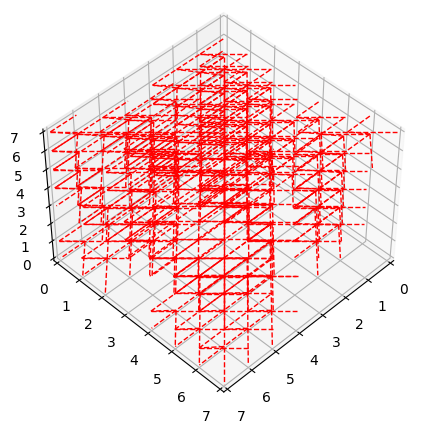

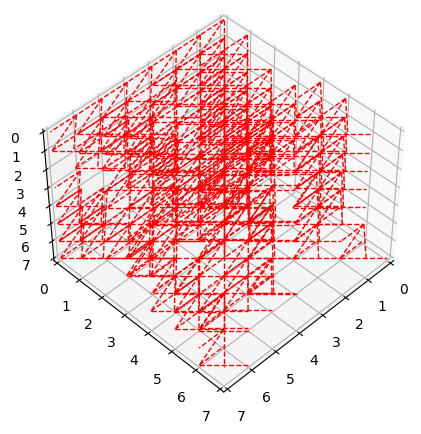

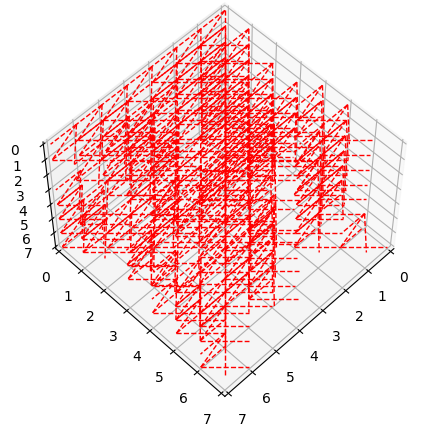

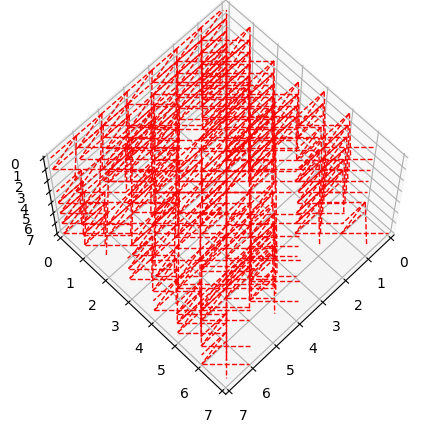

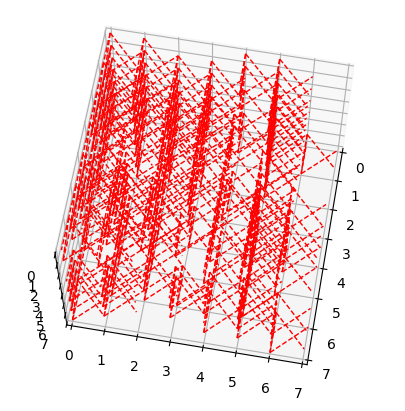

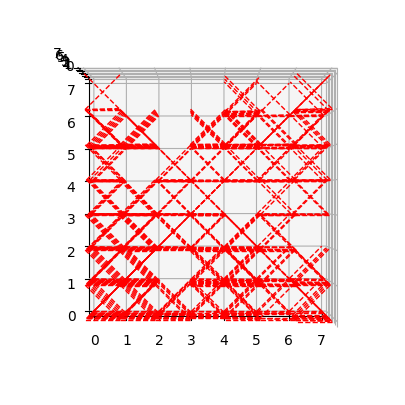

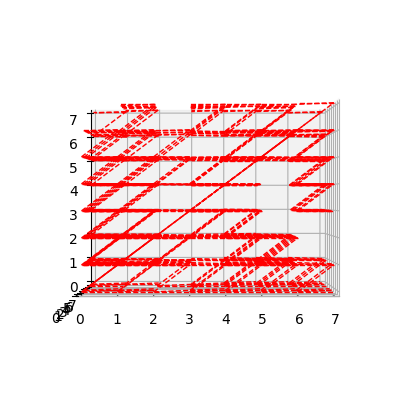

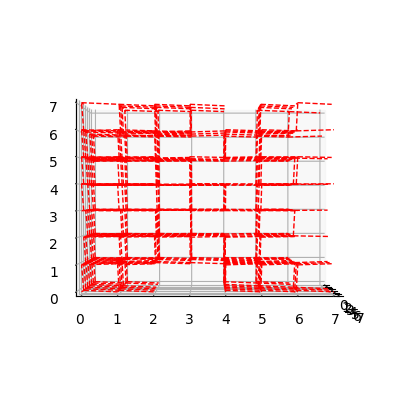

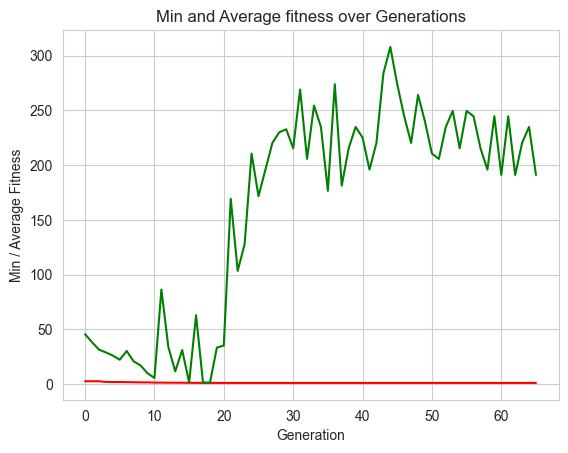

2:06:13.127143


In [30]:
startTime1 = datetime.now()
main()
print(datetime.now() - startTime1)